In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy

# Clustering with K-means

In this exercise we revisit the k-means algorithm. First you will implement the algorithm and run it on a Gaussian mixture toy-dataset, then apply it to a dataset of pulsar candidate observations.   

### 1) Gaussian mixture data
*1.1) Write a function which generates toy-data drawn from a Gaussian mixture model. The samples are drawn from $k$ Gaussian clusters of random means and uniform covariance $\Sigma = \sigma \mathbb{I}_{dxd}$. Each cluster has $n_k = \frac{n_{\textrm{samples}}}{k}$ data points $\in \mathbb{R}^{d}$. The output dataset should have shape (n_samples, d).*

In [4]:
def generate_gaussian_mixture_data(k, samples_per_component, d=2, mean_range=(-10, 10), std_dev=1.0):
    """
    Generates data from a Gaussian mixture model.

    Parameters:
    k (int): Number of components.
    samples_per_component (int): Number of samples from each of the k clusters to generate.
    mean_range (tuple): The range of means for the Gaussian components.
    std_dev (float): (Uniform) standard deviation for each component.

    Returns:
    numpy.ndarray: Generated dataset with shape (k*samples_per_component, d).
    """
    # your code here
    for i in range(k):
        sigma_i = np.random.uniform(low=mean_range[0], high=mean_range[1], size=(1, d))
        if i == 0:
            data = np.random.normal(loc=sigma_i, scale=std_dev, size=(samples_per_component, d))
        else:
            data = np.vstack((data, np.random.normal(loc=sigma_i, scale=std_dev, size=(samples_per_component, d))))
    return data

*1.2)  Draw a $d = 2$ dataset with some $k\sim \mathcal{O}(1)$ and plot the data points in the 2-dimensional space.*

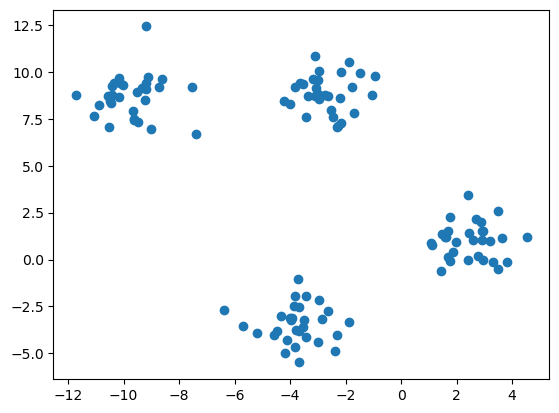

In [10]:
# your code here
k = 4
np.random.seed(42)
data = generate_gaussian_mixture_data(k, 30)

plt.scatter(data[:, 0], data[:, 1])
plt.show()

### 2) K-means implementation

*2.1) Implement the k-means algorithm. Return the estimated cluster means and cluster asssignments of each iteration, not only the final state.*   

In [152]:
def kmeans(data, k, max_iters=100, tol=1e-3):
    """
    Implements the K-Means clustering algorithm and tracks the history of centroids and assignments.

    Parameters:
    data (numpy.ndarray): Data points for clustering.
    k (int): Number of clusters.
    max_iters (int): Maximum number of iterations.
    tol (float): Iteration stops if all centroids have moved less than tol

    Returns:
    tuple: (final_centroids, final_cluster_assignments, centroids_history, assignments_history)
    """ 
    # empty lists to append centroids and assignments (cluster index of each data point) from each iteration
    centroids_history = []
    assignments_history = []
    
    # your code from here
    
    # Initialize centroids randomly
    centroids = np.random.uniform(low=np.min(data), high=np.max(data), size=(k, data.shape[1]))
    centroids_history.append(centroids.copy())

    for _ in range(max_iters):
        # Assign data points to the nearest centroid
        dist_mat = scipy.spatial.distance.cdist(data, centroids, metric='euclidean')
        cluster_assignments = np.argmin(dist_mat, axis=1)
        assignments_history.append(cluster_assignments.copy())

        # Update centroids
        for i in range(k):
            tmp = data[cluster_assignments == i]
            if tmp.shape[0] >0:
                centroids[i] = np.mean(tmp, axis=0)

        # Append centroids and assignments to history

        centroids_history.append(centroids.copy())

        # Check for convergence (if all centroids do not move more than tol, then break)
        centroids_diff = np.linalg.norm(centroids_history[-1] - centroids_history[-2], axis=1)
        # print(centroids_diff)
        if np.all(centroids_diff < tol):
            break
    # Assign data points to final centroids
    dist_mat = scipy.spatial.distance.cdist(data, centroids, metric='euclidean')
    cluster_assignments = np.argmin(dist_mat, axis=1)
    assignments_history.append(cluster_assignments.copy())
    
    return centroids, cluster_assignments, centroids_history, assignments_history


*2.2) Apply your implementation to the Gaussian mixture toy-data, and use the provided ```plot_kmeans_iterations()``` function to visualize how centroids and cluster assignments evolve over the iterations.*  
*If you like, play around with the number of clusters in the data and in the algorithm, or vary how well-seperated the data clusters are, and observe the k-means dynamics. Do you notice failure modes?*

In [138]:
import matplotlib.pyplot as plt

def plot_kmeans_iterations(data, centroids_history, assignments_history):
    """
    Plots K-Means iterations showing centroids and data point assignments.

    Parameters:
    data (np.array of shape (n_samples,2)): Data points.
    centroids_history (list of (k,2) shape np.arrays): List of the centroids at each iteration.
    assignments_history (list of (k) shape np.arrays): List of data point assignments at each iteration.
    """
    n_iters = len(centroids_history)
    plt.figure(figsize=(15, 5 * n_iters))

    for i in range(n_iters):
        plt.subplot(n_iters, 1, i + 1)
        plt.scatter(data[:, 0], data[:, 1], c=assignments_history[i], alpha=0.5, marker='.')
        plt.scatter(centroids_history[i][:, 0], centroids_history[i][:, 1], c='red', marker='X')
        plt.title(f'Iteration {i+1}')
        plt.xlabel('X')
        plt.ylabel('Y')

    plt.tight_layout()
    plt.show()


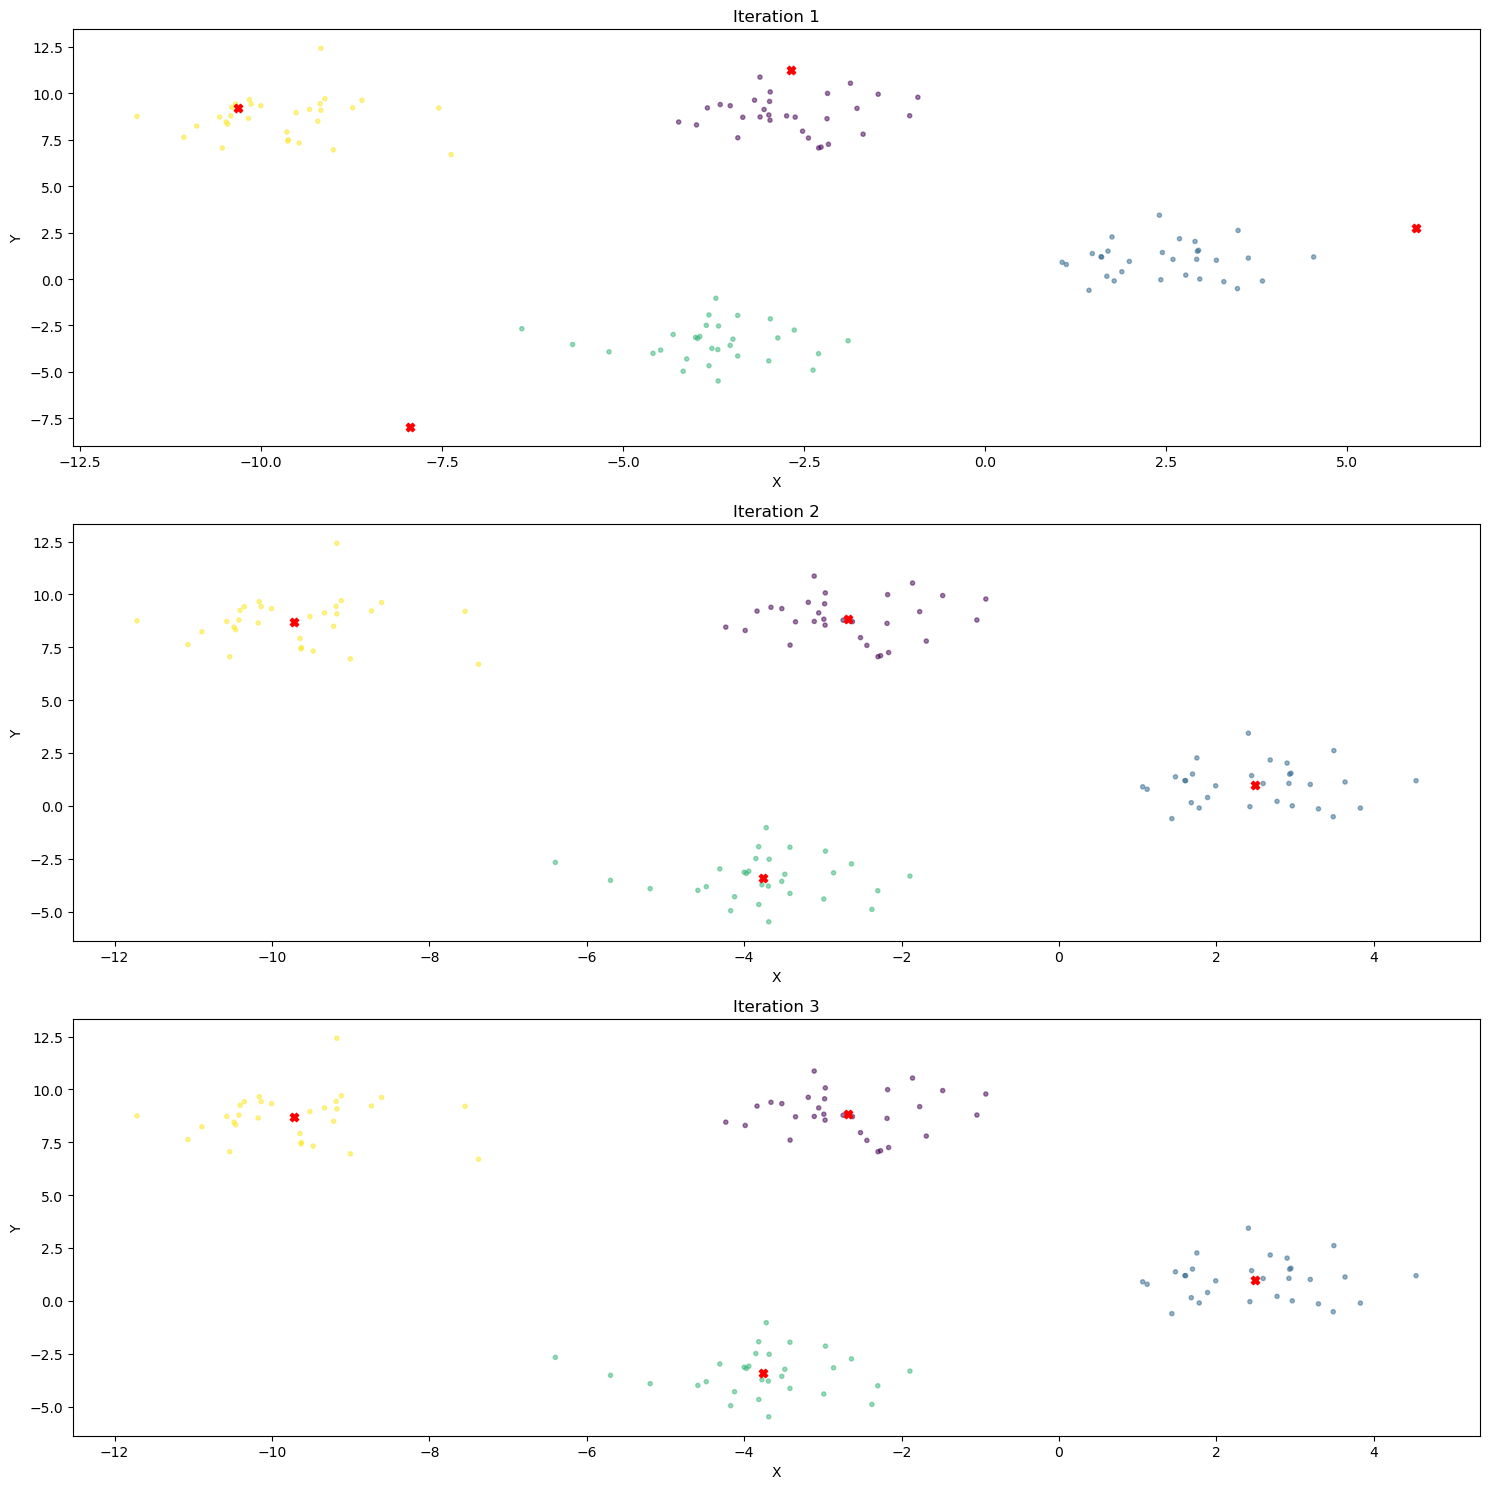

In [157]:
# apply kmeans() to the toy-data and plot the iterations.
np.random.seed(42)
centroids, cluster_assignments, centroids_history, assignments_history = kmeans(data, k=4, max_iters=100, tol=1e-3)
plot_kmeans_iterations(data, centroids_history, assignments_history)

### 3) Clustering of pulsar observation data
We now consider a dataset of pulsar candidates from the HTRU survey. You can download the data and read the description of the data on the [UCI machine learning repository](https://archive.ics.uci.edu/dataset/372/htru2). The .csv file is also provided on Moodle with the exercise. Our goal is to see in how far pulsars and false pulsar candidates are represented by two different clusters which we can automatically discover via clustering. While this is a very simple method, k-means has been applied extensively in scientific data analysis, for an example from astrophysics similar to our pulsar candidate clustering here, see [Turner et al. 2019](https://academic.oup.com/mnras/article/482/1/126/5116177) who are clustering galaxy survey data. But now to the pulsar candidates.  


*3.1) Read the description and familiarize yourself with the data. Load it from the ```.csv``` file, for example using ```np.loadtxt()```, then investigate some basic questions such as:*
- *How many samples and features are there?*
- *What is the mean and variance of the different features?*
- *How many true pulsars and how many non-pulsars are in the data?*

In [161]:
import pandas as pd

In [165]:
# load the data 
df = pd.read_csv("HTRU_2.csv", header=None)

In [169]:
# explore it a bit
df.head()

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0


In [174]:
df.mean()

0    111.079968
1     46.549532
2      0.477857
3      1.770279
4     12.614400
5     26.326515
6      8.303556
7    104.857709
8      0.091574
dtype: float64

In [175]:
df.std()

0     25.652935
1      6.843189
2      1.064040
3      6.167913
4     29.472897
5     19.470572
6      4.506092
7    106.514540
8      0.288432
dtype: float64

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>,
        <Axes: title={'center': '2'}>],
       [<Axes: title={'center': '3'}>, <Axes: title={'center': '4'}>,
        <Axes: title={'center': '5'}>],
       [<Axes: title={'center': '6'}>, <Axes: title={'center': '7'}>,
        <Axes: >]], dtype=object)

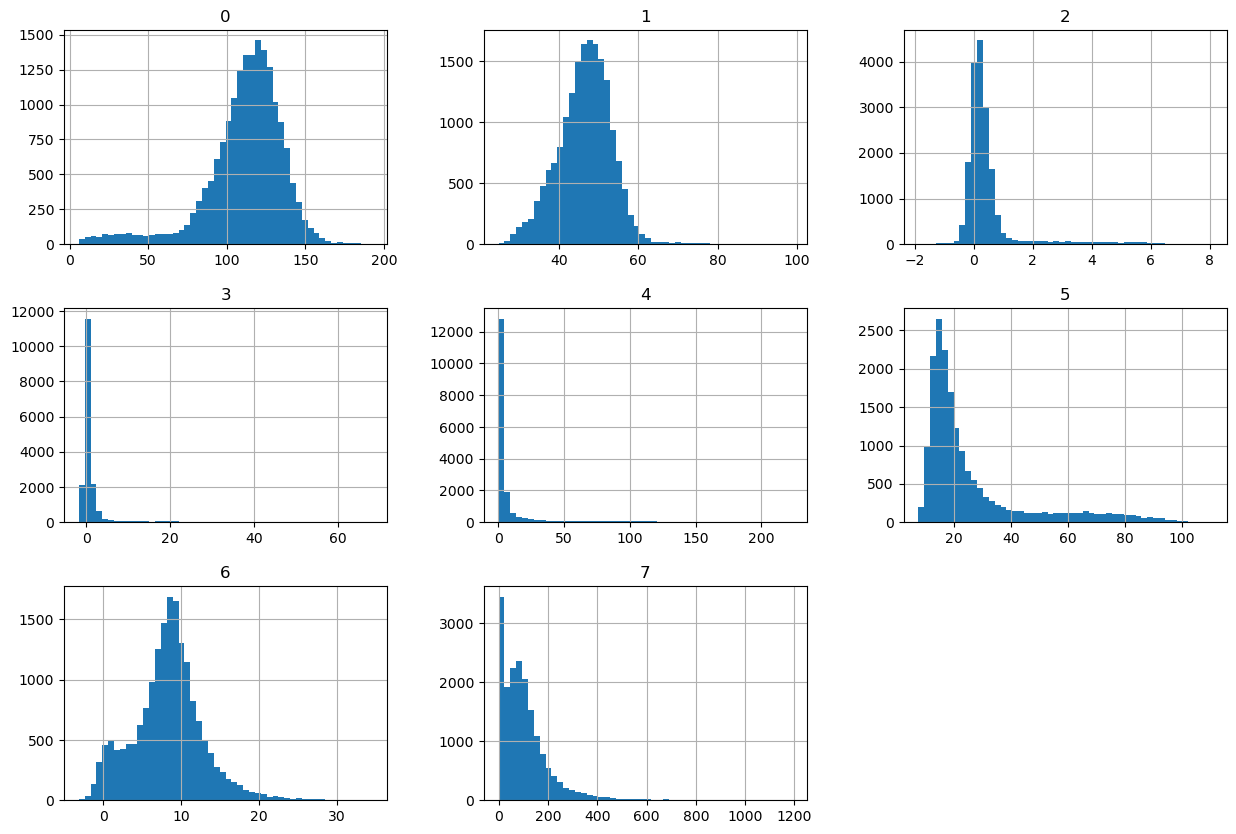

In [176]:
df.loc[:, 0:7].hist(figsize=(15, 10), bins=50)

In [180]:
df[df.loc[:, 8] == 1]

,0,1,2,3,4,5,6,7,8
19,99.367188,41.572202,1.547197,4.154106,27.555184,61.719016,2.208808,3.662680,1
42,120.554688,45.549905,0.282924,0.419909,1.358696,13.079034,13.312141,212.597029,1
61,27.765625,28.666042,5.770087,37.419009,73.112876,62.070220,1.268206,1.082920,1
92,23.625000,29.948654,5.688038,35.987172,146.568562,82.394624,-0.274902,-1.121848,1
93,94.585938,35.779823,1.187309,3.687469,6.071070,29.760400,5.318767,28.698048,1
...,...,...,...,...,...,...,...,...,...
17515,89.867188,47.482295,1.591325,2.505057,0.763378,12.393561,17.940745,333.902630,1
17529,27.039062,33.754722,4.779124,26.255357,129.863712,78.815440,-0.348492,-0.893791,1
17558,77.070312,39.000638,1.884421,6.372178,38.517559,65.741059,1.589513,1.285346,1
17642,28.375000,27.649311,6.377273,45.944048,141.860368,82.893017,-0.477222,-1.067880,1


In [181]:
df[df.loc[:, 8] == 0]

,0,1,2,3,4,5,6,7,8
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,0
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,0
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,0
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,0
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,0
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,0
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,0
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,0
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,0


*3.2) Remove the column containing the labels, since we want to do unsupervised learning. The ground-truth labels will be used later to assess our clustering result.*
*Furthermore, before throwing k-means at the data, would it be useful to preprocess it by standardizing mean and variance of the data, e.g. using ```sklearn.preprocessing.StandardScaler```? Could it hurt to do this?*

In [195]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [182]:
# split features and labels
ys = df.loc[:, 8].values
xs = df.loc[:, 0:7].values

In [186]:
ys.shape, xs.shape

((17898,), (17898, 8))

In [196]:
# choose whether to preprocess by standardizing
scaler = StandardScaler()
xs_stan = scaler.fit_transform(xs)


*3.3) Look for the k-means implementation in sklearn and apply it to the data. Use n_clusters=2.*

In [199]:
# your code here
km = KMeans(n_clusters=2, random_state=42, n_init=10)
km.fit(xs_stan)

KMeans(n_clusters=2, n_init=10, random_state=42)

*3.4) Get the cluster assignment of each sample. We want to compare these to the true labels and evaluate the performance of our clustering. Note that for binary classification, there are always 4 possible outcomes: True positive, true negative, false positive and false negative. The accuracy, that is the percentage of correctly classified samples, is just one of many metrics build from the [8 basic ratios](https://en.wikipedia.org/wiki/Binary_classification#Evaluation_of_binary_classifiers) used to evaluate binary classifiers. In general it is safe to say that there exists a slightly confusing amount of classification and performance metrics even for [standard cases](https://scikit-learn.org/stable/modules/model_evaluation.html#). This is just to let you know, so when you encounter keywords like informedness, recall, micro-averaged accuracy, F1 score, perplexity, or confusion matrix, as usual, keep calm and read the documentation.*  
*The [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) is in fact an intuitive generalization of the true/false positives/negatives in binary classification to the multi-class case. Of course it can thus also be used in the binary case. Use ```confusion_matrix()``` or ```ConfusionMatrixDisplay.from_predictions()``` from ```sklearn.metrics``` to assess the fit between your cluster labels and the true labels.* 

In [201]:
# get the cluster index for the data samples
km.labels_

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

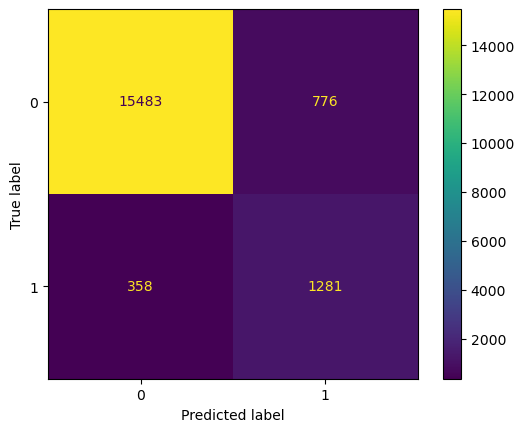

In [206]:
# plot or print the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
conf_mat = confusion_matrix(ys, km.labels_)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()
plt.show()

*3.5) Compute also the accuracy. Is this a good metric here?*  
*(Note that the cluster indices may need to be flipped to align with the labels.)*

In [208]:
# your code here
acc = np.sum(np.diag(conf_mat)) / np.sum(conf_mat)
print(f"Accuracy: {acc:.2f}")

Accuracy: 0.94


*3.6) Use the plotting function provided below, and inspect the resulting 2d slices of the clusters colored by cluster index and true label. Read through the function to see how it handles the coloring and plotting. Note that plotting functions can often be generated quite well by Large Language Models (LLMs), as this function was, with some modifcations.*

In [209]:
def plot_pulsar_clusters_vs_labels(X, y, y_pred):
    """
    Plots the results of k-means clustering against actual labels.

    This function visualizes the comparison between k-means clustering predictions 
    (y_pred) and actual labels (y) for each pair of features in the dataset. 
    It uses different colors to indicate true positives, true negatives, false negatives,
    and false positives.

    Parameters:
    X (numpy.ndarray): The feature data set. Each row represents a sample, 
                       and each column represents a feature.
    y (numpy.ndarray): The actual labels for each sample. This array is 1-dimensional.
    y_pred (numpy.ndarray): The predicted labels from k-means clustering. 
                            This array is 1-dimensional.

    The function creates scatter plots for each pair of features in the data set.
    """
    
    feature_names = ['Mean of the integrated profile',
                     'Standard deviation of the integrated profile',
                     'Excess kurtosis of the integrated profile',
                     'Skewness of the integrated profile',
                     'Mean of the DM-SNR curve',
                     'Standard deviation of the DM-SNR curve',
                     'Excess kurtosis of the DM-SNR curve',
                     'Skewness of the DM-SNR curve']

    # making a coloring array for scatterplots
    lightred = np.array([0.9, 0, 0])
    red = np.array([0.4, 0, 0])
    yellow = np.array([0.9, 0.9, 0])
    blue = np.array([0, 0, 0.9])

    data_coloring = np.zeros((y.size, 3))
    data_coloring[(y_pred == 1) & (y == 1)] = yellow  # True positive
    data_coloring[(y_pred == 0) & (y == 0)] = blue    # True negative
    data_coloring[(y_pred == 0) & (y == 1)] = red     # False negative
    data_coloring[(y_pred == 1) & (y == 0)] = lightred # False positive

    for i in range(4):
        dims = [2 * i, 2 * i + 1]
        plt.figure(figsize=(8, 6))
        plt.title('k-means prediction vs. label')
        plt.scatter(X[:, dims[0]], X[:, dims[1]], c=data_coloring, marker='.', alpha=0.6)
        plt.xlabel(feature_names[dims[0]])
        plt.ylabel(feature_names[dims[1]])

        # Adding legend
        plt.scatter([], [], color=yellow, label='True Positive')
        plt.scatter([], [], color=blue, label='True Negative')
        plt.scatter([], [], color=red, label='False Negative')
        plt.scatter([], [], color=lightred, label='False Positive')
        plt.legend()

        plt.show()


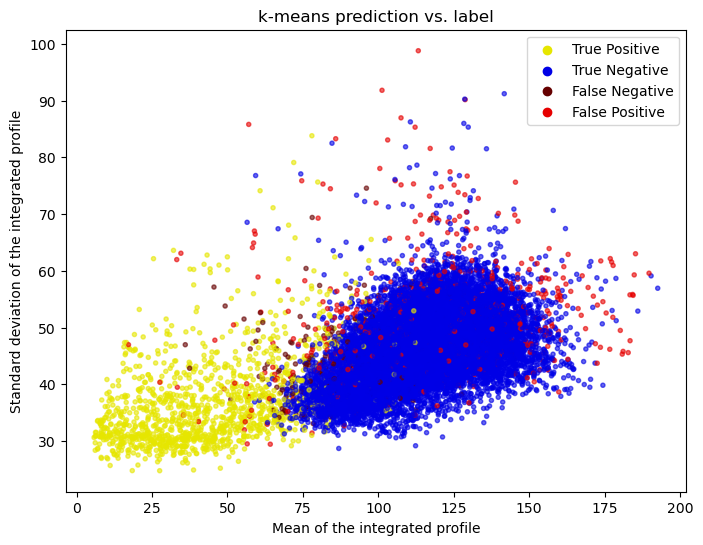

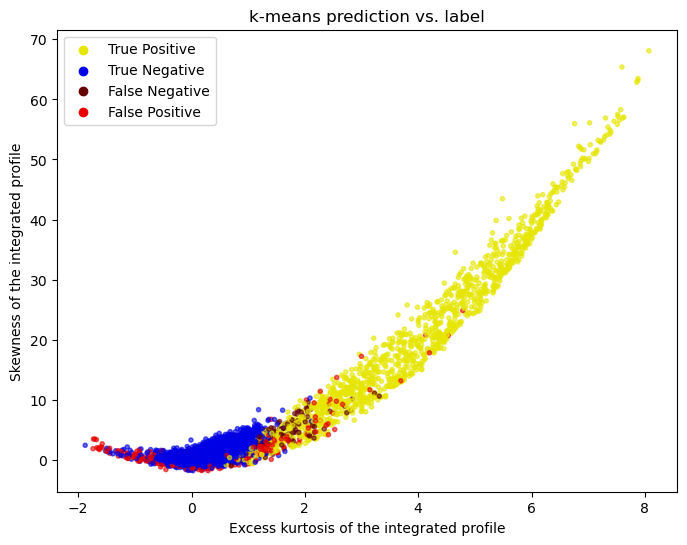

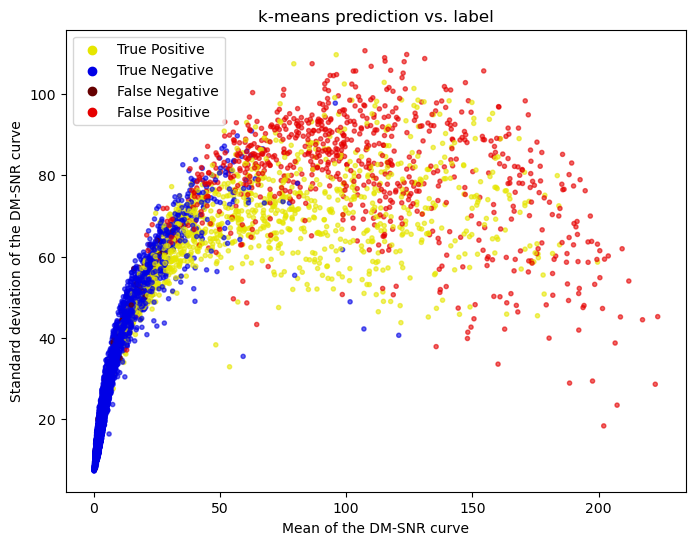

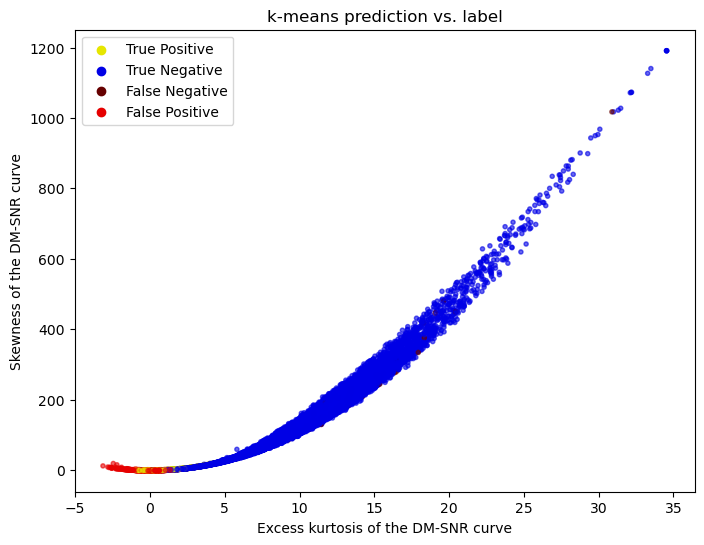

In [212]:
# in case the kmeans 0 labels correspond best to the ground truth 1 label, flip them if you have not done already
plot_pulsar_clusters_vs_labels(xs, ys, km.labels_)

In [17]:
# call plot_pulsar_clusters_vs_labels()
